In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Phrases
from collections import Counter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

#Loading the data
df = pd.read_csv('your/path')
df['pub_date'] = pd.to_datetime(df['pub_date'])
display(df.head())
print('There are {} articles and {} columns'.format(df.shape[0], df.shape[1]))

,title,descr,url,news_kw,pub_date,text,pub_hour
0,The Top WIRED Photo Stories of 2018,Want to give your eyes a break from the news c...,https://www.wired.com/story/best-wired-photo-s...,"photo,Photography",2018-12-31,['The Hellish E-Waste Graveyards Where Compute...,9
1,The 2018 Internet Moments That Made Being Onli...,'A Star Is Born' birthed great memes and Zenda...,https://www.wired.com/story/best-internet-mome...,"culture,Year in Review,memes,internet culture",2018-12-31,"[""The internet, as recent Senate reports have ...",9
2,Big Tech Is Here to Help You Fight Excessive P...,"How the large tech corporations turned ""digita...",https://www.wired.com/story/how-big-tech-co-op...,"gear,Year in Review,digital wellness,Tristan H...",2018-12-31,"['In early February, the technologist Tristan ...",7
3,How to Follow New Horizons' Historic Flyby of ...,"On New Year's Eve, NASA's probe will reach Ult...",https://www.wired.com/story/how-to-follow-new-...,"science,New Horizons,space,NASA,Astronomy,astr...",2018-12-31,"[""For the past 13 years, NASA's New Horizons s...",7
4,The Worst Hacks of 2018,From the Marriott revelation and Facebook melt...,https://www.wired.com/story/worst-hacks-2018-f...,"security,Year in Review,hacking,cybersecurity,...",2018-12-31,"['After years of targeted hacks, epic heists, ...",7


There are 4102 articles and 7 columns


In [5]:
#Descriptive statistics for the number of articles published per day
art_day = pd.DataFrame(df.groupby('pub_date')['pub_date'].count().describe()).rename(columns = {'pub_date': 'Articles by Day'})
art_day

,Articles by Day
count,365.00
mean,11.24
std,5.78
min,3.00
25%,7.00
50%,11.00
75%,14.00
max,58.00


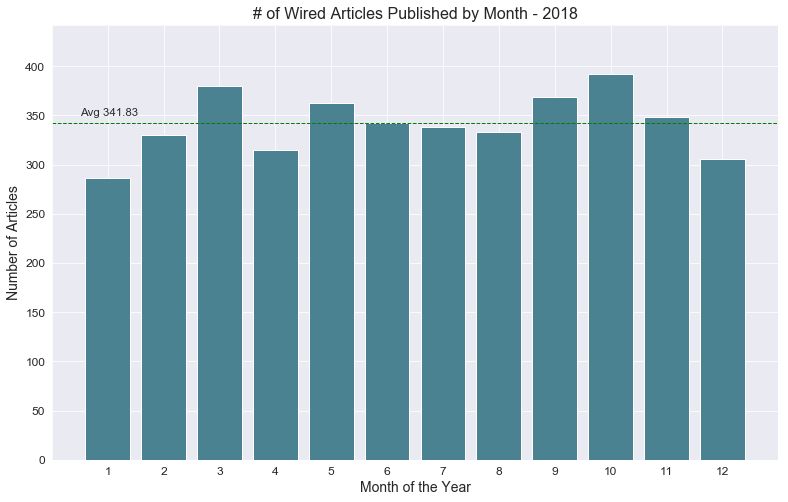

In [6]:
#Looking at the number of articles per month
df['pub_month'] = df['pub_date'].dt.month 
tot_per_month = df.groupby(['pub_month','pub_date'])['pub_date'].count()
avg = np.round(np.mean(tot_per_month.groupby('pub_month').sum()), decimals=2)
tot_per_month = pd.DataFrame(tot_per_month.groupby('pub_month').sum().reset_index()).rename(columns = {'pub_month': 'Month of the Year', 'pub_date': '# of Articles'})

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.set(style="darkgrid") 
plt.bar(tot_per_month['Month of the Year'], tot_per_month['# of Articles'], color='#4A8292')
plt.xlabel('Month of the Year', fontsize=14)
plt.xticks(fontsize=12)
ax.set_xticks(list(range(1,13)))           
plt.ylabel('Number of Articles', fontsize=14)
plt.yticks(fontsize=12)
axes = plt.gca()
axes.set_ylim([0, tot_per_month['# of Articles'].max() + 50])
ax.axhline(avg, color='green', linewidth=1, linestyle='--')
plt.text(.5,350,'Avg {}'.format(avg), color='#2d2d2d', fontsize=11.5)
plt.title('# of Wired Articles Published by Month - 2018', fontsize=16)
plt.show()

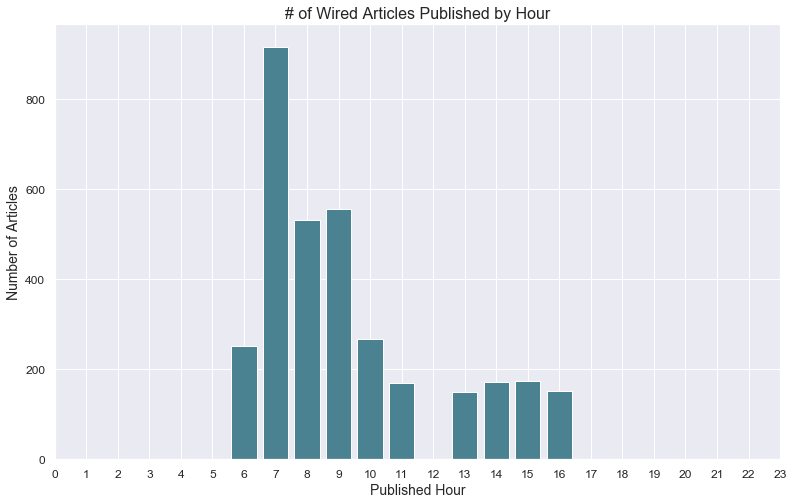

In [7]:
#10 most popular hours to publish articles
df2 = df.groupby(['pub_hour'])['pub_hour'].count()
df2 = df2.sort_values(ascending=False).head(10)

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.set(style="darkgrid") 
plt.bar(df2.index, df2.values, color='#4A8292')
plt.xlabel('Published Hour', fontsize=14)
plt.xticks(fontsize=12)
ax.set_xticks(list(range(0,24)))           
plt.ylabel('Number of Articles', fontsize=14)
plt.yticks(fontsize=12)
axes = plt.gca()
axes.set_ylim([0, df2.max() + 50])
plt.title('# of Wired Articles Published by Hour', fontsize=16)
plt.show()

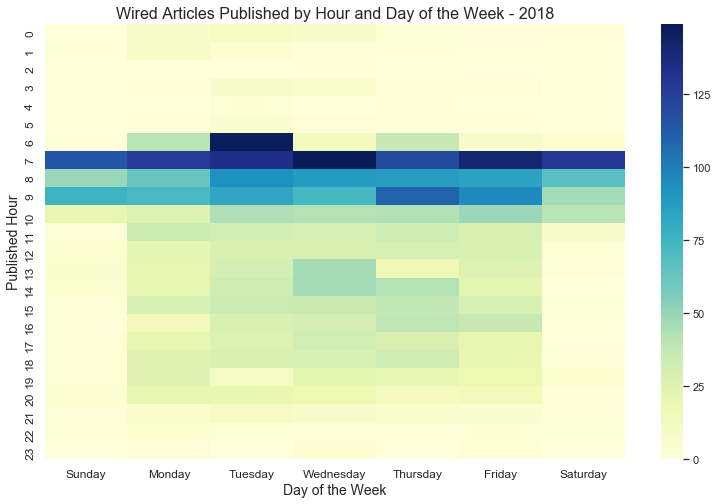

In [8]:
#Heatmap for published hour by day of the week
df['dow'] = df['pub_date'].dt.weekday_name
df_pub_time = df.groupby(['pub_hour', 'dow'])['text'].count().reset_index()
df_pub_time = pd.pivot_table(df_pub_time, values = 'text', columns = 'dow', index = 'pub_hour', aggfunc='sum')
df_pub_time = df_pub_time.fillna(0)
cols = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_pub_time = df_pub_time[cols]

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(df_pub_time, cmap="YlGnBu")
plt.xlabel('Day of the Week', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Published Hour', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Wired Articles Published by Hour and Day of the Week - 2018', fontsize=16)
plt.show()

In [9]:
#Next I'll look at word_count by article
#Each article has a disclaimer at the bottom starting with CNMN Collections so I'll just remove that first
df['text'] = df['text'].apply(lambda x: x.split('CNMN Collection')[0])
#Getting the word_count for each article
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(' ')))
#Descriptive statistics
pd.DataFrame(df['word_count'].describe())

,word_count
count,"4,102.00"
mean,"1,220.58"
std,947.16
min,144.00
25%,786.00
50%,"1,025.50"
75%,"1,337.75"
max,"12,130.00"


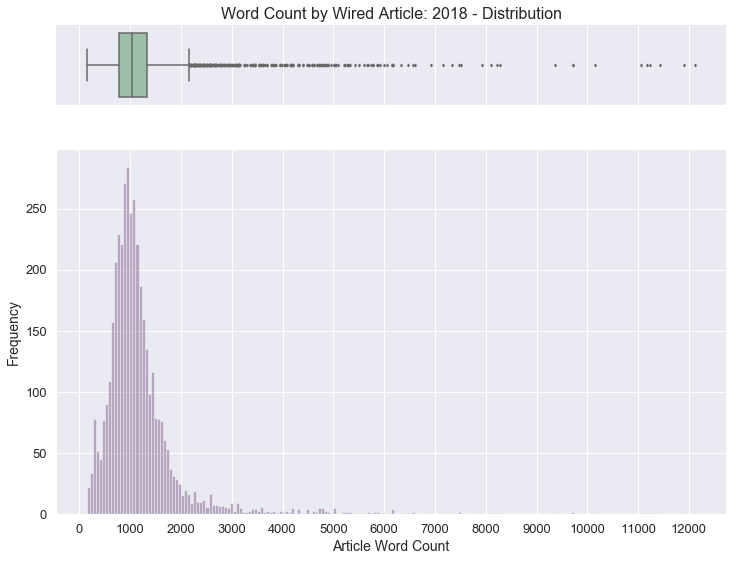

In [10]:
x = df['word_count']

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True,  figsize=(12,9), gridspec_kw={"height_ratios": (.18, .82)})
sns.boxplot(x, ax=ax_box, fliersize=2, color = '#96C5A5')
sns.distplot(x, ax=ax_hist, bins = 200, kde=False, color = '#654473')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Article Word Count', fontsize=14)
plt.xticks(np.arange(min(x)-144, max(x)+1,1000), fontsize=13)
plt.yticks(fontsize=13)
ax_box.set_xlabel('')
ax_box.set_title('Word Count by Wired Article: 2018 - Distribution', fontsize=16)
plt.show()

In [40]:
#Top 5 articles for word_count
sort = df.sort_values(by = 'word_count', ascending = False).head()
sort[['title', 'url', 'word_count']]

,title,url,word_count
2224,Inside the Crypto World's Biggest Scandal,https://www.wired.com/story/tezos-blockchain-l...,12130
3823,How to Design Beacons for Humanity's Afterlife,https://www.wired.com/story/how-to-design-beac...,11902
472,Has Silicon Valley Lost Its Soul? The Case for...,https://www.wired.com/story/intelligence-squar...,11430
3678,Inside Facebook's Two Years of Hell,https://www.wired.com/story/inside-facebook-ma...,11242
3075,2001: A Space Odyssey Predicted the Future—50 ...,https://www.wired.com/story/2001-a-space-odyss...,11182


In [20]:
#Analyzing the key words for each article
kw_list = df['news_kw'].tolist()

#Function to split each word on the comma, flatten into a single list, replace the whitespace with an underscore and lowercase everything
def kw_clean(list_of_keywords):
    tokenize = [(each).split(',') for each in list_of_keywords]
    flatten = [each for sublist in tokenize for each in sublist]
    chain = [each.replace(' ', '_') for each in flatten]
    lower = [each.lower() for each in chain]
    return lower

cleaned_kw = kw_clean(kw_list)

#Example
cleaned_kw[:10]

['photo',
 'photography',
 'culture',
 'year_in_review',
 'memes',
 'internet_culture',
 'gear',
 'year_in_review',
 'digital_wellness',
 'tristan_harris']

In [21]:
#Top 20 most frequent keywords
from collections import Counter
with_counts = Counter(cleaned_kw)
top = with_counts.most_common(20)
top

[('science', 915),
 ('business', 716),
 ('culture', 673),
 ('security', 526),
 ('transportation', 510),
 ('gear', 484),
 ('facebook', 422),
 ('google', 208),
 ('climate_change', 196),
 ('artificial_intelligence', 194),
 ('photo', 168),
 ('self-driving_cars', 161),
 ('social_media', 159),
 ('ideas', 151),
 ('movies', 149),
 ('apple', 139),
 ('cybersecurity', 137),
 ('backchannel', 134),
 ('physics', 125),
 ('privacy', 123)]

In [22]:
#Top 20 key words that appear alongside the ai key word
df['news_kw'] = df['news_kw'].apply(lambda x: x.lower())
df_ai = df.loc[df['news_kw'].str.contains('artificial intelligence|^ai$')]

ai_kw_list = df_ai['news_kw'].tolist()
cleaned_ai_kw = kw_clean(ai_kw_list)
with_counts = Counter(cleaned_ai_kw)
top = with_counts.most_common(20)
top

[('artificial_intelligence', 194),
 ('business', 86),
 ('machine_learning', 38),
 ('science', 26),
 ('google', 20),
 ('facebook', 16),
 ('microsoft', 12),
 ('backchannel', 11),
 ('ai', 11),
 ('ideas', 9),
 ('amazon', 8),
 ('facial_recognition', 7),
 ('culture', 7),
 ('longreads', 7),
 ('neuroscience', 7),
 ('wired25', 7),
 ('china', 6),
 ('self-driving_cars', 6),
 ('deep_learning', 6),
 ('neural_networks', 5)]

In [23]:
#Creating a column for whether an article contains an ai keyword (1) or not (0)
df['ai_kw'] = np.where(df['news_kw'].str.contains("artificial intelligence|^ai$", case=False), 1, 0)
df.groupby(['ai_kw'])['ai_kw'].count()

ai_kw
0    3966
1     136
Name: ai_kw, dtype: int64

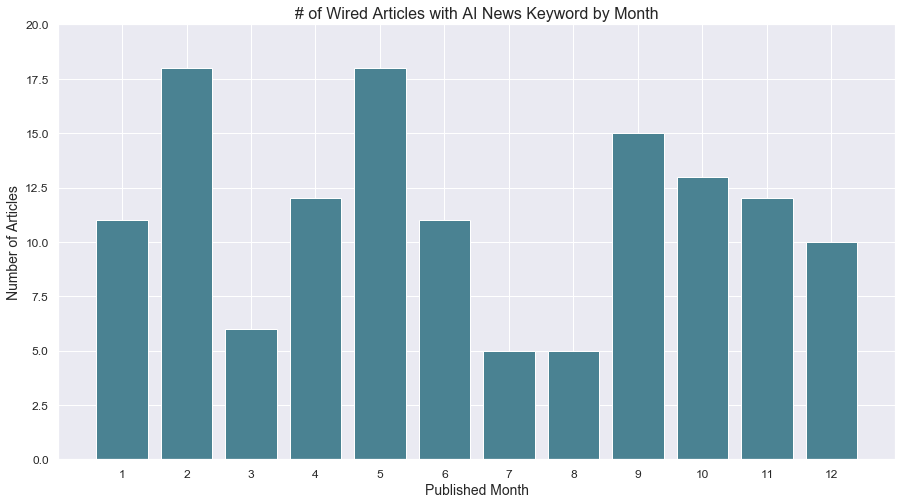

In [24]:
#Articles with ai news keyword by month
df_ai_by_month = df.groupby(['pub_month', 'ai_kw'])['text'].count().reset_index()
df_ai_by_month = df_ai_by_month.loc[df_ai_by_month['ai_kw'] == 1]
df_ai_by_month = df_ai_by_month.drop(['ai_kw'], 1)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.set(style="darkgrid") 
plt.bar(df_ai_by_month['pub_month'], df_ai_by_month['text'], color='#4A8292')
plt.xlabel('Published Month', fontsize=14)
plt.xticks(fontsize=12)
ax.set_xticks(list(range(1,13)))
plt.ylabel('Number of Articles', fontsize=14)
plt.yticks(fontsize=12)
plt.title('# of Wired Articles with AI News Keyword by Month', fontsize=16)
axes = plt.gca()
axes.set_ylim([0, df_ai_by_month['text'].max() + 2])
plt.show()

In [25]:
#Function to preprocess the text. Tokenize, lower, expand contactions, lemmatize, remove punctuation, numbers and stop words
%run nlp_utils_wired.ipynb #Loading additional functions not shown here but provided in the notebook

def pre_process_text(text):
    tokenized = casual_tokenizer(text)
    lower = [item.lower() for item in tokenized] 
    decontract = [expandContractions(item, c_re=c_re) for item in lower]
    tagged = nltk.pos_tag(decontract)
    lemma = lemma_wordnet(tagged)
    no_num = [re.sub('[0-9]+', '', each) for each in lemma]
    no_punc = [w for w in no_num if w not in punc]
    no_stop = [w for w in no_punc if not w in stop_words]
    return no_stop

In [26]:
#Applying the function to the df and creating a new column with the processed text
df['clean_text'] = df['text'].apply(lambda x: pre_process_text(x))
df.head()

,title,descr,url,news_kw,pub_date,text,pub_hour,pub_month,dow,Word Count,ai_kw,clean_text
0,The Top WIRED Photo Stories of 2018,Want to give your eyes a break from the news c...,https://www.wired.com/story/best-wired-photo-s...,"photo,photography",2018-12-31,['The Hellish E-Waste Graveyards Where Compute...,9,12,Monday,967,0,"[hellish, e-waste, graveyard, computer, metal,..."
1,The 2018 Internet Moments That Made Being Onli...,'A Star Is Born' birthed great memes and Zenda...,https://www.wired.com/story/best-internet-mome...,"culture,year in review,memes,internet culture",2018-12-31,"[""The internet, as recent Senate reports have ...",9,12,Monday,1705,0,"[internet, recent, senate, report, awful, conf..."
2,Big Tech Is Here to Help You Fight Excessive P...,"How the large tech corporations turned ""digita...",https://www.wired.com/story/how-big-tech-co-op...,"gear,year in review,digital wellness,tristan h...",2018-12-31,"['In early February, the technologist Tristan ...",7,12,Monday,1182,0,"[early, february, technologist, tristan, harri..."
3,How to Follow New Horizons' Historic Flyby of ...,"On New Year's Eve, NASA's probe will reach Ult...",https://www.wired.com/story/how-to-follow-new-...,"science,new horizons,space,nasa,astronomy,astr...",2018-12-31,"[""For the past 13 years, NASA's New Horizons s...",7,12,Monday,865,0,"[past, year, nasa's, new, horizon, spacecraft,..."
4,The Worst Hacks of 2018,From the Marriott revelation and Facebook melt...,https://www.wired.com/story/worst-hacks-2018-f...,"security,year in review,hacking,cybersecurity,...",2018-12-31,"['After years of targeted hacks, epic heists, ...",7,12,Monday,1544,0,"[year, targeted, hack, epic, heist, run, data,..."


In [27]:
#Example of processed text
print(str(df['clean_text'][0][:100]) + '...')

['hellish', 'e-waste', 'graveyard', 'computer', 'metal', 'wonder', 'old', 'battery', 'phone', 'light-up', 'toy', 'wind', 'answer', 'dump', 'ghana', 'china', 'india', 'kai', 'löffelbein', 'eye-opening', 'book', 'ctrl-x', 'topography', 'e-waste', 'rare', 'look', 'inside', 'korean', 'dmz', 'scary', 'place', 'earth', 'nthe', 'mile', 'korean', 'demilitarize', 'zone', 'contain', 'large', 'concentration', 'soldier', 'artillery', 'world', 'park', 'jongwoo', 'receive', 'rare', 'permission', 'photograph', 'inside', 'zone', 'accompany', 'course', 'squadron', 'soldier', 'hilarious', 'image', 'bored', 'tourist', 'world', 'neach', 'summer', 'traveler', 'descend', 'europe', 'church', 'museum', 'landmarks', 'laurence', 'stephen', 'right', 'photograph', 'photograph', 'image', 'appear', 'fun', 'new', 'book', 'year', 'ominous', 'view', "japan's", 'new', 'concrete', 'seawall', 'ngray', 'wall', 'line', 'coast', 'northeast', 'japan', 'entire', 'village', 'destroy', 'tsunami', 'tadashi', 'ono', 'document', '

In [28]:
#Simple word frequency (top 50) for articles with the ai news keyword tag
df_ai = df.loc[df['news_kw'].str.contains('artificial intelligence|^ai$')]
text_list = df_ai['clean_text'].tolist()
flatten = [each for sublist in text_list for each in sublist]
with_counts = Counter(flatten)
with_counts.most_common(20)

[('ai', 1231),
 ('company', 774),
 ('make', 699),
 ('people', 697),
 ('human', 673),
 ('work', 629),
 ('technology', 556),
 ('machine', 520),
 ('year', 504),
 ('google', 498),
 ('new', 494),
 ('data', 480),
 ('think', 443),
 ('time', 431),
 ('thing', 406),
 ('help', 386),
 ('algorithm', 372),
 ('computer', 370),
 ('intelligence', 369),
 ('image', 361)]

In [29]:
#Frequency for just bigrams (2 words that appear together frequently)
def bigram_freq(text_list, top_n):
    bigram_model = Phrases(text_list, min_count=3, threshold=1)
    w_bigrams = list(bigram_model[text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = [each for each in flat_w_bigrams if '_' in each]
    with_counts = Counter(bigrams)
    return with_counts.most_common(top_n)

bigram_freq(text_list, 20)

[('artificial_intelligence', 243),
 ('machine_learning', 167),
 ('machine_learn', 97),
 ('neural_network', 88),
 ('deep_learning', 81),
 ('silicon_valley', 62),
 ('facial_recognition', 60),
 ('hate_speech', 60),
 ('tech_company', 57),
 ('year_ago', 57),
 ('neural_net', 45),
 ('self-driving_car', 39),
 ('san_francisco', 36),
 ('computer_science', 35),
 ('free_energy', 34),
 ('social_medium', 32),
 ('ai_researcher', 31),
 ('past_year', 30),
 ('computer_scientist', 30),
 ('training_data', 28)]